In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px


In [2]:

data_dir = "C:\\Users\\heineib\\Google Drive\\Crick_LMS\\Wetlab\\RNA_seq\\20210315_pombe_ox_stress\\"
#Moved data from rcs to laptop after copying log and counts in the same file

#Make single table of Sequencing characteristics

strains = ['WT', '758', '759', '762','838']
conds = ['cont','L','M']
times = ['20', '60']

seq_metadata = {}

for strain in strains: 
    for cond in conds: 
        for time in times: 
            seq_metadata[strain + '_' + time + '_' + cond] = {'strain':strain, 
                                                              'cond': cond, 
                                                              'time': time
                                                             }

            qc_stats = {"Number of input reads": 'input_reads',
                        "Uniquely mapped reads %": 'uniquely_mapped_pct',
                        "% of reads mapped to multiple loci": 'multiple_loci_pct',
                        "% of reads unmapped: too many mismatches": 'pct_unmapped_mismatches',
                        "% of reads unmapped: too short": 'pct_unmapped_short',
                        "% of reads unmapped: other": 'pct_unmapped_other',
                        "% of chimeric reads": 'pct_chimeric',
                        "Mismatch rate per base, %": 'mismatch_rate', 
                        "Deletion rate per base": 'deletion_rate',
                        "Insertion rate per base": 'insertion_rate'
                       }

            fname = data_dir + strain + '_' + time + '_' + cond + '_Log.final.out'

            qc_stats_keys = qc_stats.keys()
            with open(fname,'r') as logfile:
                for line in logfile: 
                    qc_stat = line.split("|")[0].strip() 
                    if qc_stat in qc_stats_keys:
                        seq_metadata[strain + '_' + time + '_' + cond][qc_stats[qc_stat]] = line.split("|")[1].strip()


seq_metadata_df = pd.DataFrame(seq_metadata).T


In [34]:
#Add metadata from the counts files

# for strain in strains: 
#     for cond in conds: 
#         for time in times: 


col_list = [(1,'unstranded'), (2,'fwd'), (3,'rev')]

metadata_to_add = {'N_unmapped': [],                 # These are already included in the metadata above.  
                   'N_multimapping': []}

for col_no, col in col_list: 
    metadata_to_add['Total_' + col] = []
    for metadata_name in ['N_noFeature', 'N_ambiguous']: 
        metadata_to_add[metadata_name + '_' + col] = []
        metadata_to_add[metadata_name + '_pct_' + col] = []

        
all_counts = {}

totals = {}

for sample_name in seq_metadata_df.index: 
    fname = data_dir + sample_name + '_ReadsPerGene.out.tab'

    counts_table=pd.read_table(fname, index_col=0, header=None)
    total_reads = counts_table.drop(['N_unmapped', 'N_multimapping', 'N_noFeature', 'N_ambiguous']).sum()
    totals[sample_name] = total_reads[2]
    
    all_counts[sample_name] = counts_table.iloc[4:,2]
    
    
    for metadata_name in['N_unmapped', 'N_multimapping']: #These values are the same for all columns
        metadata_to_add[metadata_name].append(counts_table.loc[metadata_name,1])  
        
    for col_no,col in col_list: 
        col_total = total_reads[col_no]
        metadata_to_add['Total_'+ col].append(col_total)
        for metadata_name in ['N_noFeature', 'N_ambiguous']: 
            col_metadata = counts_table.loc[metadata_name,col_no]
            metadata_to_add[metadata_name + '_' + col].append(col_metadata) 
            metadata_to_add[metadata_name + '_pct_' + col].append(col_metadata/col_total)

            
            
#build all_counts_df
all_counts_df = pd.DataFrame(all_counts)
            
# build seq_metadata_df and clean up columns
for key, col_data in metadata_to_add.items(): 
    seq_metadata_df[key] = col_data

#Convert 'input_reads' column to integer (it starts as a datetime)
seq_metadata_df['input_reads'] = seq_metadata_df['input_reads'].astype(int)     

#Convert various pct columns to float (they start as strings)

pct_cols = ['uniquely_mapped_pct', 'multiple_loci_pct', 'pct_unmapped_short', 
            'mismatch_rate', 'deletion_rate', 'insertion_rate']
for col_name in pct_cols:
    new_col = [float(pct_val.strip('%'))/100 for pct_val in seq_metadata_df[col_name]]
    seq_metadata_df[col_name + '_float'] = new_col


#Keep only the third column - which should be the reverse strand, but looks like it might be the forward strand.  
#The NcRNA numbers however seem to be backwards.  They seem to have the most numbers in the forward column.  Maybe they overlap with coding RNA on the other strand? 

#Make a single table of data from the counts files.  

#Save metadata and total counts
seq_metadata_df.to_csv(data_dir + 'metadata_summary.csv' )
all_counts_df.to_csv(data_dir + 'raw_counts.csv')

In [35]:
#Normalize by total, multiply by size_factor, add pseudocount
size_factor = np.mean([totals[col] for col in totals.keys()])  #Median of total number of reads so that the median sample would have reads at the same scale as the actual counts.  
all_counts_norm = all_counts_df.copy()
pseudocount = 0.1 #Chosen to be 10% of a single count in a typical sample to avoid division by zero during normalization. 
for col in all_counts_df.columns:
    all_counts_norm[col] = all_counts_df[col]*size_factor/totals[col] + pseudocount



#For each strain, get fold change vs WT_20_cont.  

strains = ['WT', '758', '759', '762','838']
conds = ['cont','L','M']
times = ['20', '60']

all_counts_fc_by_strain = all_counts_norm.copy()

for strain in strains: 
    base_col = strain + '_20_cont' 
    for time in times: 
        for cond in conds: 
            col = strain + '_' + time + '_' + cond
            all_counts_fc_by_strain[col] = all_counts_norm[col]/all_counts_norm[base_col]
            
all_counts_fc_by_strain.to_csv(data_dir + 'counts_norm_by_strain_t20_cont.csv')
            
        
#get fold change VS WT_20_cont between strains

time = '20'
cond = 'cont'
            
all_counts_fc_base_cols = all_counts_norm.loc[:, [ strain + '_' + time + '_' + cond for strain in strains]].copy()

for strain in strains: 
    base_col = 'WT_20_cont'
    col = strain + '_' + time + '_' + cond
    all_counts_fc_base_cols[col] = all_counts_norm[col]/all_counts_norm[base_col]
            
all_counts_fc_base_cols.to_csv(data_dir + 'counts_norm_strain_to_WT_base_col.csv')

In [44]:
#Filter on mean number of counts across all conditions

mean_filter = 10.0  #Keep only genes whose mean is greater than this.  

filt_set = all_counts_norm.mean(axis=1)>mean_filter

all_counts_fc_by_strain_filt = all_counts_fc_by_strain[filt_set]
all_counts_fc_by_strain_filt.to_csv(data_dir + 'counts_norm_by_strain_t20_cont_filt.csv')

all_counts_fc_base_cols_filt = all_counts_fc_base_cols[filt_set]
all_counts_fc_base_cols_filt.to_csv(data_dir + 'counts_norm_strain_to_WT_base_col_filt.csv')


In [13]:
all_counts_norm

,WT_20_cont,WT_60_cont,WT_20_L,WT_60_L,WT_20_M,WT_60_M,758_20_cont,758_60_cont,758_20_L,758_60_L,...,762_20_L,762_60_L,762_20_M,762_60_M,838_20_cont,838_60_cont,838_20_L,838_60_L,838_20_M,838_60_M
0,,,,,,,,,,,,,,,,,,,,,
SPAC212.11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000547,0.000553,...,0.006671,0.003013,0.002734,0.000786,0.053495,0.049357,0.028637,0.023746,0.028007,0.011841
SPAC212.10,0.000000,0.000547,0.000493,0.000000,0.000000,0.000453,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000569,0.000000,0.000000,0.000000,0.000000,0.000564
SPAC212.09c,0.000000,0.000547,0.000000,0.000000,0.000000,0.000000,0.000628,0.000000,0.000000,0.000000,...,0.000477,0.000430,0.000000,0.000393,0.000000,0.000555,0.003369,0.000528,0.000000,0.000000
SPNCRNA.70,0.000000,0.000000,0.000000,0.000506,0.000515,0.000453,0.001885,0.002771,0.002188,0.002214,...,0.000477,0.002152,0.000456,0.001965,0.002845,0.001664,0.000562,0.000528,0.003631,0.000000
SPAC212.08c,0.004188,0.003282,0.006903,0.004047,0.006186,0.004980,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.011382,0.008873,0.004492,0.009499,0.010892,0.004511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SPMIT.10,0.000598,0.002188,0.002958,0.000506,0.000000,0.003622,0.001257,0.002771,0.003282,0.000000,...,0.005718,0.008178,0.002278,0.001179,0.001138,0.000555,0.000562,0.001055,0.001556,0.000564
SPMITTRNAALA.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SPMITNCRNA.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.002264,0.000000,0.000554,0.000547,0.000553,...,0.000477,0.001722,0.000000,0.000000,0.001707,0.000000,0.002246,0.000000,0.000000,0.000000


In [84]:
#Calculate Transcripts per million: 

In [5]:
seq_metadata_df

,strain,cond,time,input_reads,uniquely_mapped_pct,mismatch_rate,deletion_rate,insertion_rate,multiple_loci_pct,pct_unmapped_mismatches,...,N_noFeature_rev,N_noFeature_pct_rev,N_ambiguous_rev,N_ambiguous_pct_rev,uniquely_mapped_pct_float,multiple_loci_pct_float,pct_unmapped_short_float,mismatch_rate_float,deletion_rate_float,insertion_rate_float
WT_20_cont,WT,cont,20,17292111,96.45%,0.26%,0.01%,0.00%,2.56%,0.00%,...,1277130,0.083541,114335,0.007479,0.9645,0.0256,0.0092,0.0026,0.0001,0.0000
WT_60_cont,WT,cont,60,18507295,96.41%,0.26%,0.01%,0.00%,2.65%,0.00%,...,1263794,0.076854,135807,0.008259,0.9641,0.0265,0.0081,0.0026,0.0001,0.0000
WT_20_L,WT,L,20,19710970,96.40%,0.24%,0.01%,0.00%,2.68%,0.00%,...,1318425,0.075157,140456,0.008007,0.9640,0.0268,0.0082,0.0024,0.0001,0.0000
WT_60_L,WT,L,60,18999885,96.35%,0.24%,0.01%,0.00%,2.68%,0.00%,...,1227331,0.072399,126277,0.007449,0.9635,0.0268,0.0087,0.0024,0.0001,0.0000
WT_20_M,WT,M,20,17101158,95.99%,0.26%,0.01%,0.00%,2.68%,0.00%,...,1473764,0.099403,115207,0.007771,0.9599,0.0268,0.0089,0.0026,0.0001,0.0000
WT_60_M,WT,M,60,19580981,95.20%,0.24%,0.01%,0.00%,3.40%,0.00%,...,1863329,0.112071,150619,0.009059,0.9520,0.0340,0.0087,0.0024,0.0001,0.0000
758_20_cont,758,cont,20,16431599,95.49%,0.69%,0.02%,0.02%,3.13%,0.00%,...,1250132,0.087229,108195,0.007549,0.9549,0.0313,0.0120,0.0069,0.0002,0.0002
758_60_cont,758,cont,60,18005610,95.04%,0.67%,0.02%,0.02%,3.19%,0.00%,...,1255410,0.079824,129852,0.008257,0.9504,0.0319,0.0148,0.0067,0.0002,0.0002
758_20_L,758,L,20,18606223,95.38%,0.67%,0.02%,0.02%,3.12%,0.00%,...,1247031,0.076245,143865,0.008796,0.9538,0.0312,0.0130,0.0067,0.0002,0.0002
758_60_L,758,L,60,18567027,95.50%,0.66%,0.02%,0.02%,3.05%,0.00%,...,1384682,0.085395,131975,0.008139,0.9550,0.0305,0.0124,0.0066,0.0002,0.0002


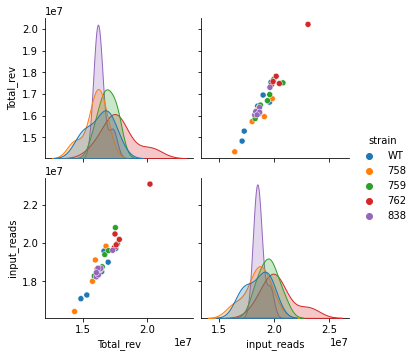

In [59]:
sns.pairplot(seq_metadata_df.loc[:, ['strain','Total_rev', 'input_reads']] ,  hue='strain')

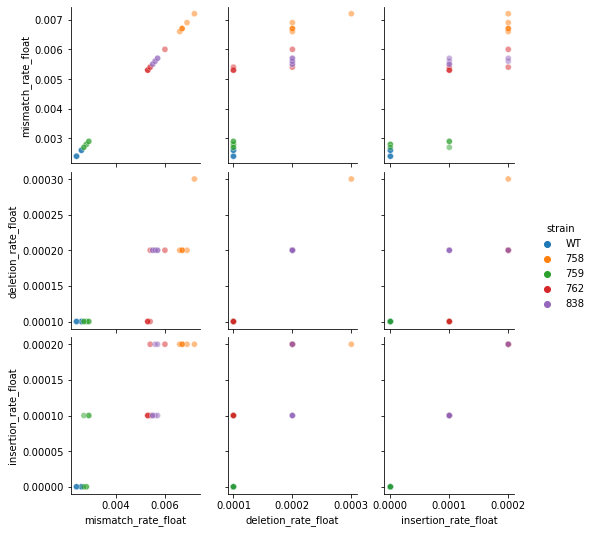

In [65]:
sns.pairplot(seq_metadata_df, vars = ['mismatch_rate_float', 'deletion_rate_float','insertion_rate_float'] ,  hue='strain', diag_kind= None, plot_kws = {'alpha':0.5})

<AxesSubplot:xlabel='strain', ylabel='mismatch_rate_float'>

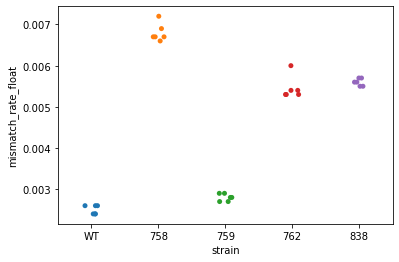

In [69]:
sns.stripplot(x='strain', y='mismatch_rate_float', data=seq_metadata_df)

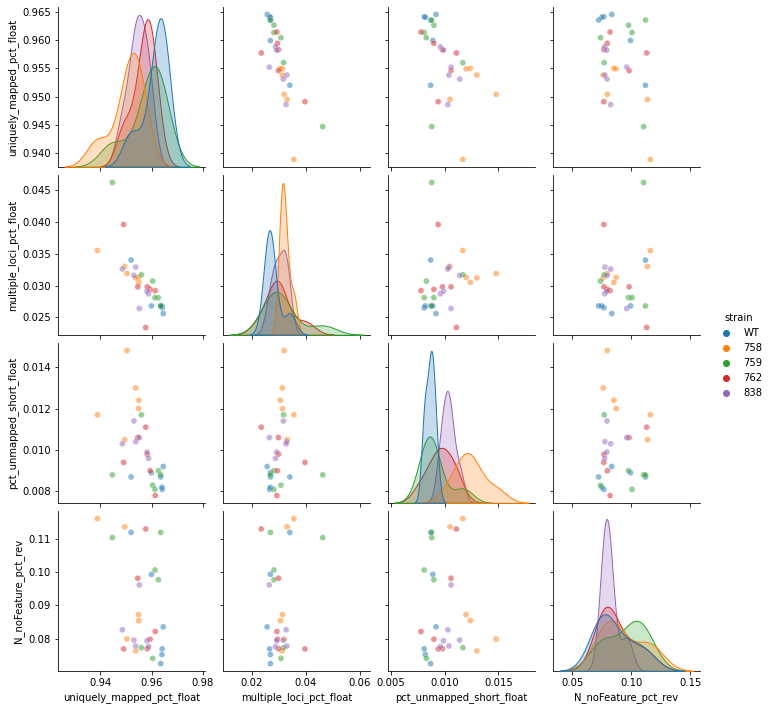

In [67]:
sns.pairplot(seq_metadata_df, vars = ['uniquely_mapped_pct_float','multiple_loci_pct_float', 'pct_unmapped_short_float', 'N_noFeature_pct_rev'] ,  hue='strain', plot_kws = {'alpha':0.5})

<AxesSubplot:xlabel='strain', ylabel='pct_unmapped_short_float'>

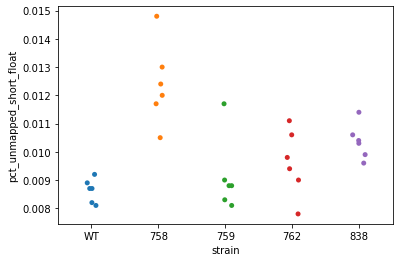

In [70]:
sns.stripplot(x='strain', y='pct_unmapped_short_float', data=seq_metadata_df)

<AxesSubplot:xlabel='strain', ylabel='multiple_loci_pct_float'>

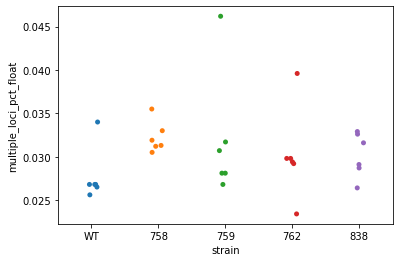

In [71]:
sns.stripplot(x='strain', y='multiple_loci_pct_float', data=seq_metadata_df)

In [ ]:
#Make single table of data
#Load count data for all samples

#Ran STAR on the GPU cluster /home/heineike/github/rna_seq_processing/star/20170817_klscpka_alignment.py

#make a data panel containing counts for each species. 
#Keep only the second column - this is stranded data so this corresponds to the strand that is listed in the GFF file. 

species = ['KL', 'SC']
data_panels = {}
counts_raw = {}
counts = {}
rows_to_remove = ['N_unmapped','N_multimapping','N_noFeature','N_ambiguous']


for spec in species: 
    labels = metadata[metadata['species']==spec].index
    
    data_dict = {}
    for label in labels:
        data_dict[label] = pd.read_table(base_dir + str(label) + '_ReadsPerGene.out.tab', index_col = 0, header = None)

    data_panels[spec] = pd.Panel(data_dict)
    
    #take the second column which is for stranded library preparation protocols
    counts_raw_w_metadata = data_panels[spec].minor_xs(2)

    #remove the metadata rows.
    counts_raw[spec] = counts_raw_w_metadata.drop(rows_to_remove)

    ### Do I need to do any normalization?  Why is this the right kind of normalization? 

    #add up the counts and normalize by total - then multiplies by the mean number of counts to get a number on the same scale 
    #as original counts.  

# Save raw and normalized counts as an entire data structure
fname_counts_pkl = data_processing_dir + '20170817_klscpka/20170817_klscpka_counts.pkl'
output = open(fname_counts_pkl, 'wb')
pickle.dump(counts, output)
output.close()